# GPU-accelerated hierarchical matrices for triangular dislocation elements.

Last time, we investigate the low-rank property of the far-field blocks of a BEM matrix and built an adaptive cross approximation (ACA) implementation. Remember, the goal is to find a way to handle dense BEM matrices without running into the brick wall of $O(n^2)$ algorithmic scaling. With scaling like that, even a very powerful machine can't handle medium sized problems with 100,000 elements. The low-rank property will be the key to solving this problem. 

This time, we'll put the pieces together and actually build a $O(n\log{n})$ algorithm for matrix-vector products that's not just theoretically faster, but also much faster in practice! To do this, we'll build a hierarchical matrix (H-matrix) implementation for TDE matrices. While I'll just focus on performing matrix-vector products with the approximation, it's possible to do much more with H-matrices -- for example, a compressed and accelerated LU decomposition.

To build an H-matrix implementation, we need to:
1. build a tree structure in order to determine which groups of elements are far away from each other.
2. traverse that tree to split the matrix blocks into near-field and far-field blocks.
3. compute the exact matrix for each near-field block.
4. compute the approximate matrix using the ACA algorithm for each far-field block.
5. perform fast matrix-vector products with both the near-field exact matrices and the far-field approximate matrices.

Before we get into the problem, I'll rebuild the same simple (boring?) surface self-interaction matrix from previous sections. Our initial goal will be to approximate this matrix. The cell is hidden:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

import cutde

surf_L = 4000
n_els_per_dim = 50
mesh_xs = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_ys = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_xg, mesh_yg = np.meshgrid(mesh_xs, mesh_ys)
surf_pts = np.array([mesh_xg, mesh_yg, 0 * mesh_yg]).reshape((3, -1)).T.copy()
surf_tris = []
nx = ny = n_els_per_dim + 1
idx = lambda i, j: i * ny + j
for i in range(n_els_per_dim):
    for j in range(n_els_per_dim):
        x1, x2 = mesh_xs[i : i + 2]
        y1, y2 = mesh_ys[j : j + 2]
        surf_tris.append([idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)])
        surf_tris.append([idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)])
surf_tris = np.array(surf_tris, dtype=np.int64)
surf_tri_pts = surf_pts[surf_tris].astype(np.float32)
surf_centroids = np.mean(surf_tri_pts, axis=1).astype(np.float32)

full_mat = cutde.disp_matrix(
    surf_centroids + np.array([0, 0, 0.01], dtype=np.float32), surf_tri_pts, 0.25
)
tmp = full_mat[:, :, :, 0].copy()
full_mat[:, :, :, 0] = full_mat[:, :, :, 1]
full_mat[:, :, :, 1] = tmp
# full_mat += np.eye(lhs_reordered.shape[0])

## The tree data structure

Ok, let's build a binary tree for determining which subsets of elements are far away from each other. What do I mean by binary-tree here? Since we're in three-dimensional space, there's not an obvious connection to the standard binary tree in one dimension. So, start with the bounding box that contains all our elements. Then, we'll split that box along its longest dimension. The two child boxes will then, themselves, be split along their respective longest dimensions. Thus, we can construct a binary tree in three dimensional space by always choosing the longest dimension for the split. 

This is closely to a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree). An [octree](https://en.wikipedia.org/wiki/Octree) would be another common choice here. Octree split on all three dimensions simultaneous meaning that each node has eight children, making them a sort of [B-tree](https://en.wikipedia.org/wiki/B-tree). I decided to go with the above binary tree concept here just because the code ends up being very simple. It also seems likely to me that a binary tree will find good splits because it will avoid long narrow boxes by splitting on the longest dimension. 

Getting back to the code, as a simplification, we'll actually model each element as a sphere that encloses the element. This is just to make distance calculations easier. So, we calculate a "radius" for each element which is simply the distance from the centroid to the corner that is furthest from the centroid. I don't believe this is actually the minimal bounding sphere, but it's easy to calculate and we're not trying to be perfectly optimal here.

In [2]:
element_radius = np.max(
    np.linalg.norm(surf_tri_pts - surf_centroids[:, None, :], axis=2), axis=1
)

Next, we'll use Python dataclasses to implement the tree and its nodes. 

The data structure here might take a bit of explanation. Let's start with the `Tree.ordered_idxs`, `TreeNode.idx_start` and `TreeNode.idx_end`. Once we've constructed a binary tree, it's possible to order the elements from left to right by simply enforcing the rule that the indices of all elements in the left hand child have indices that are less than all the indices of the right hand child. This can be achieved by re-ordering elements during the construction process: if there are $n_l$ elements in the left child, we assign them indices $0...n_l-1$. Then the $n_r$ elements in the right child will be assigned indices $n_l...n_l+n_r$. The result is that the left child can be assigned `idx_start = 0` and `idx_end = n_l` and the right child can be assigned `idx_start = n_l` and `idx_end = n_r`. If this is confusing, see below for a few figures that might help explain. 

The node `center` and `radius` are simple, but represent a simplification. While above we talked about splitting boxes into sub-boxes, it's simpler to perform distance calculations if we just store the bounding sphere of each of these boxes. Since we split on the longest dimension, the boxes will never deviate too far from being a cube and thus a sphere will be a decent approximation.

In [3]:
from dataclasses import dataclass
from typing import Optional


@dataclass()
class TreeNode:
    idx_start: int
    idx_end: int
    center: np.ndarray
    radius: float
    is_leaf: bool
    left: Optional["TreeNode"]
    right: Optional["TreeNode"]


@dataclass()
class Tree:
    ordered_idxs: np.ndarray
    root: TreeNode

The following three figures should help to explain what these trees will look like and what's going on with the `Tree.ordered_idxs` array. I've created a tree out of ten points. This first figure is showing the extent of the tree nodes for the lowest two levels of the tree along with the indices of each input point.

<img src="./tree_diagram1.svg" width="400px">

The second figure shows the structure of the binary tree itself. The leaves each contain only one input point with the point index specified. You can see how the associated nodes are also spatially associated above. Also, the tree is not a uniform depth, since the splitting depends on whether a node still has more than one point.

<img src="./tree_diagram2.svg" width="400px">

Finally, this third figure shows the entries in the `Tree.ordered_idxs` array. The indices are ordered according to the left-to-right structure of the binary tree, exactly matching the leaf nodes above. This is helpful so that spatially nearby points are also nearby in memory. In implementing the H-matrix approximation, these re-ordered indices simplify a lot of the indexing so that we can always work with contiguous blocks of indices.

<img src="./tree_diagram3.svg" width="400px">

## Building the tree

Building the tree will actually only be a couple dozen lines of code! I'm going to comment inline in the functions below.

In [4]:
def build_tree(pts, radii, min_pts_per_box=10):
    # The tree construction process receives three parameters:
    #
    # pts: the center of each element.
    #
    # radii: the radius of each element. Remember that we're dealing with spherical
    #        approximations to elements here instead of the triangular elements
    #        themselves.
    #
    # min_pts_per_box: this determines when we'll stop splitting. If a box has more
    #                  than min_pts_per_box elements, we keep splitting.

    # We'll start with the element indices in the order that they were given to this function.
    # build_tree_node will re-order these indices at each step to enforce the rule that
    # left child indices must be less than right child indices.
    ordered_idxs = np.arange(pts.shape[0])
    # The rest of the tree construction process will be handled by the recursive function:
    # build_tree_node. The last two parameters are idx_start and idx_end. For the root of the
    # tree, we pass the full set of elements: (0, pts.shape[0])
    root = build_tree_node(pts, radii, min_pts_per_box, ordered_idxs, 0, pts.shape[0])
    return Tree(ordered_idxs, root)


def build_tree_node(
    all_pts, all_radii, min_pts_per_box, ordered_idxs, idx_start, idx_end
):
    # 1) Collect the relevant element data.
    # A view into the ordered_idxs array for the elements we're working on here.
    idx_view = ordered_idxs[idx_start:idx_end]
    # And the center and radius of each element.
    pts = all_pts[idx_view]
    radii = all_radii[idx_view]

    # 2) Define the bounding box.
    box_center = np.mean(pts, axis=0)
    sep = pts - box_center[None, :]
    box_axis_length = np.max(sep, axis=0)
    box_radius = np.max(np.linalg.norm(sep, axis=1) + radii)

    # 3) Build the node
    # To start with, the left and right child are absent and is_leaf=True.
    # If the node is not a leaf, we'll overwrite these below.
    node = TreeNode(
        idx_start, idx_end, box_center, box_radius, is_leaf=True, left=None, right=None
    )

    # 4) Return if the node is a leaf node.
    # If there are fewer than min_pts_per_box elements in this node, then we do not split.
    if idx_end - idx_start <= min_pts_per_box:
        return node

    # 5) If the node is not a leaf, split!
    # First, find which axis of the box is longest
    split_d = np.argmax(box_axis_length)

    # Then identify which elements are on the left hand side of the box along that axis.
    split_val = np.median(pts[:, split_d])
    is_left = pts[:, split_d] < split_val

    # 6) Re-arrange indices.
    # Since we're going to re-arrange indices, we need to save the relevant indices first.
    left_idxs = idx_view[np.where(is_left)[0]].copy()
    right_idxs = idx_view[np.where(~is_left)[0]].copy()
    n_left = left_idxs.shape[0]
    # Then assign the left side indices to the beginning of our index block
    idx_view[:n_left] = left_idxs
    # And assign the right side indices to the end of our index block.
    idx_view[n_left:] = right_idxs

    # 7) Create children!
    idx_split = idx_start + n_left
    node.is_leaf = False

    # We recursively call build_tree_node here. The key difference between the left and right
    # sides is that the left receives the index block [idx_start, idx_split) and the right
    # receives the index block [idx_split, idx_end). Thus, we've created a smaller, equivalent
    # problem.
    node.left = build_tree_node(
        all_pts, all_radii, min_pts_per_box, ordered_idxs, idx_start, idx_split
    )
    node.right = build_tree_node(
        all_pts, all_radii, min_pts_per_box, ordered_idxs, idx_split, idx_end
    )

    return node

Let's actually build a tree!

In [5]:
tree = build_tree(surf_centroids, element_radius, min_pts_per_box=25)
print("center =", tree.root.center)
print("radius =", tree.root.radius)

center = [ 9.7656255e-07 -5.3710937e-05  0.0000000e+00]
radius = 5700.6865


At this point, my instinct is to check and make sure that the tree is actually constructed as expected. This is a quick function that recursively traverse the tree and checks that all the elements contained in a node are actually within the bounds of the node.

In [6]:
def check_tree(pts, radii, tree, node):
    if node is None:
        return True
    idxs = tree.ordered_idxs[node.idx_start : node.idx_end]
    dist = np.linalg.norm(pts[idxs] - node.center, axis=1) + radii[idxs]
    if np.any(dist > node.radius):
        return False
    else:
        return check_tree(pts, radii, tree, node.left) and check_tree(
            pts, radii, tree, node.right
        )


check_tree(surf_centroids, element_radius, tree, tree.root)

True

And let's plot the tree! I'm going to plot each level separately. Once again, this is a recursive tree traversal where a circle gets plotted for each node.

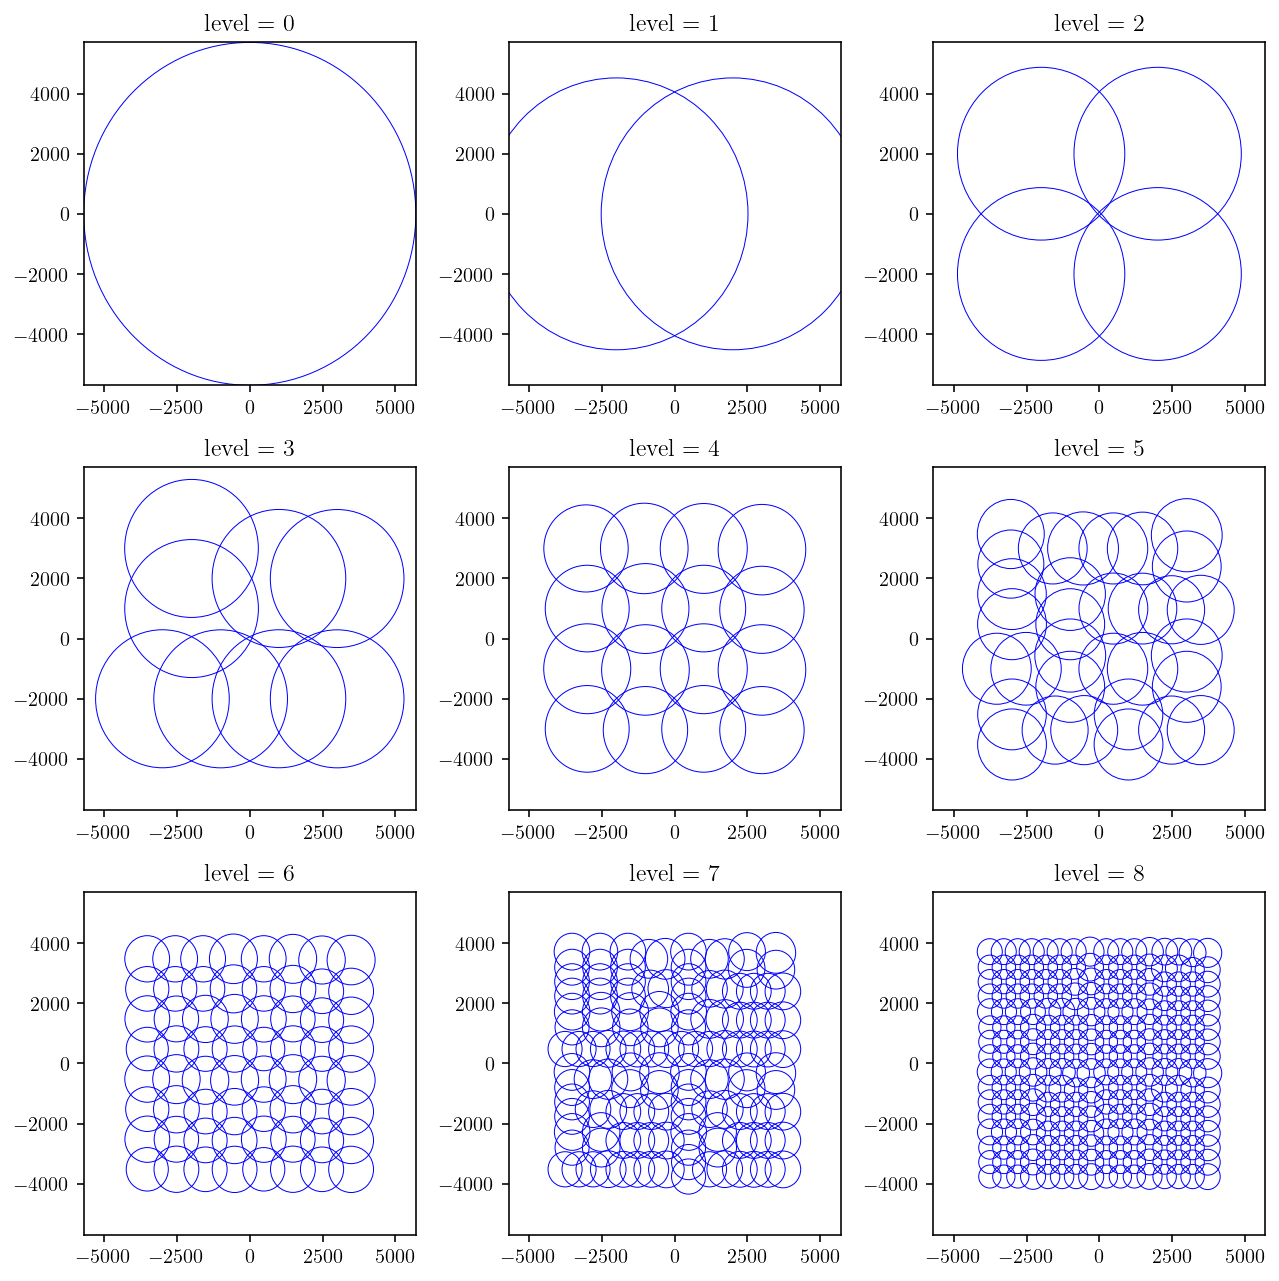

In [7]:
%matplotlib inline
def plot_tree(node, depth, **kwargs):
    if depth == 0:
        circle = plt.Circle(tuple(node.center[:2]), node.radius, fill=False, **kwargs)
        plt.gca().add_patch(circle)
    if node.left is None or depth == 0:
        return
    else:
        plot_tree(node.left, depth - 1, **kwargs)
        plot_tree(node.right, depth - 1, **kwargs)


plt.figure(figsize=(9, 9))
for depth in range(9):
    plt.subplot(3, 3, 1 + depth)
    plt.title(f"level = {depth}")
    plot_tree(tree.root, depth, color="b", linewidth=0.5)
    plt.xlim(
        [tree.root.center[0] - tree.root.radius, tree.root.center[0] + tree.root.radius]
    )
    plt.ylim(
        [tree.root.center[1] - tree.root.radius, tree.root.center[1] + tree.root.radius]
    )
plt.tight_layout()
plt.show()

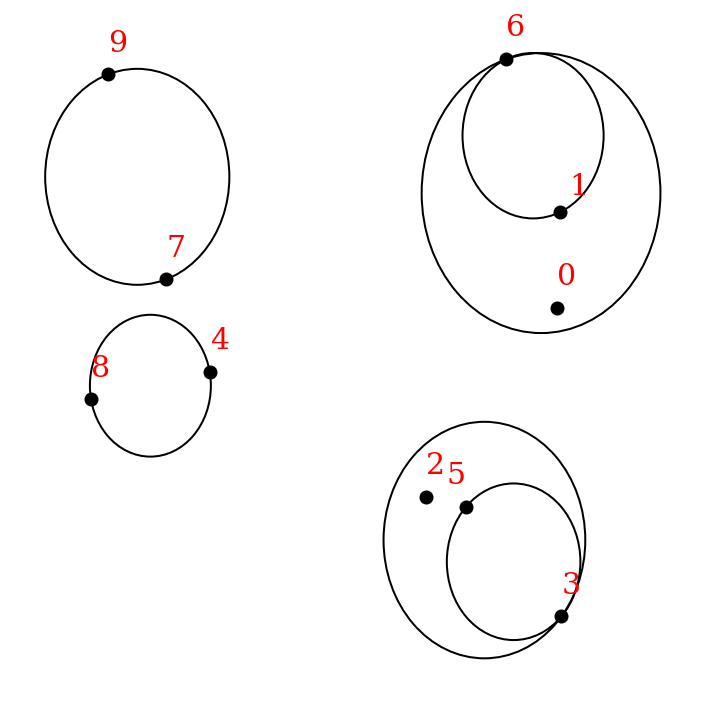

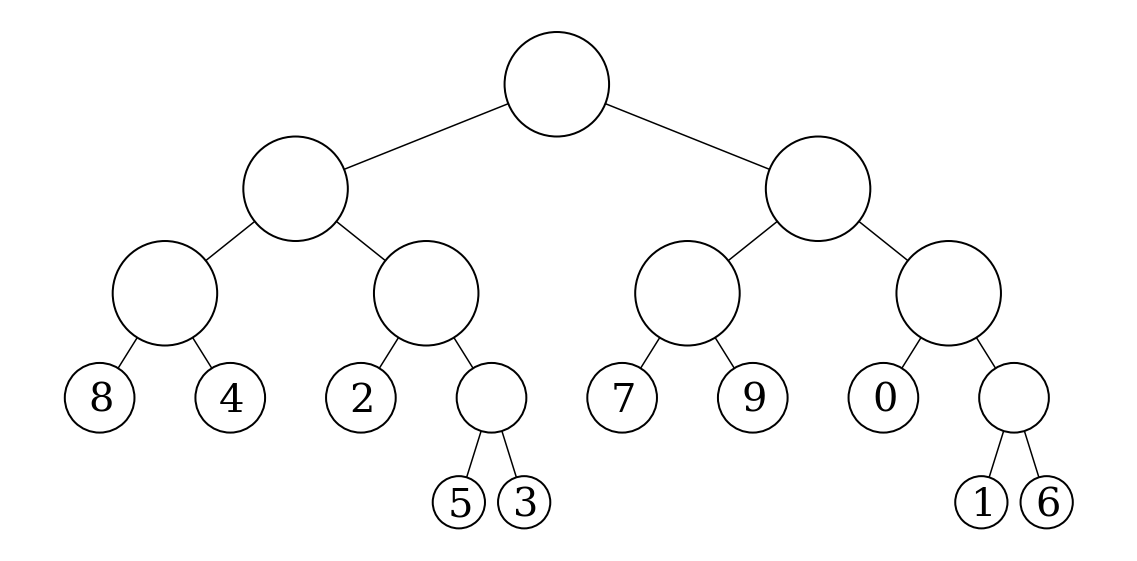

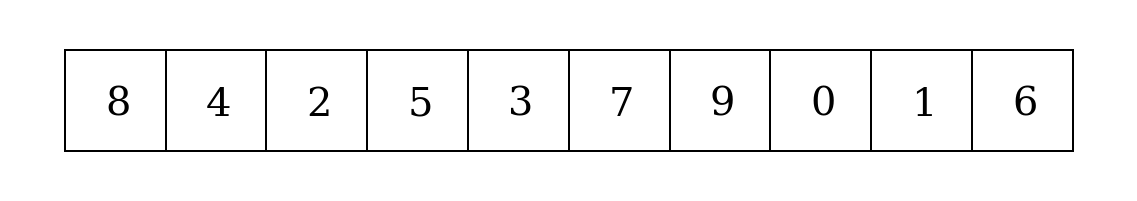

In [8]:
import matplotlib.patches as patches

np.random.seed(4)
plt.rcParams["text.usetex"] = False
original_pts = np.random.rand(10, 2)
fig_tree = build_tree(original_pts, np.zeros(original_pts.shape[0]), 1)
plt.figure(figsize=(5, 5))
plt.plot(original_pts[:, 0], original_pts[:, 1], "ko")
for i in range(10):
    tree_idx = fig_tree.ordered_idxs[i]
    x = original_pts[tree_idx, 0]
    y = original_pts[tree_idx, 1] + 0.04
    if tree_idx == 1:
        x += 0.02
        y -= 0.01
    if tree_idx == 5:
        x -= 0.04
    plt.text(x, y, str(tree_idx), fontsize=15, color="r")


def plot_tree(node):
    if not node.is_leaf:
        height = max(plot_tree(node.left), plot_tree(node.right))
    else:
        height = 0
    if height <= 2:
        circle = plt.Circle(
            tuple(node.center[:2]),
            node.radius,
            fill=False,
            color="b" if node.is_leaf else "k",
        )
        plt.gca().add_patch(circle)
    return height + 1


plot_tree(fig_tree.root)
plt.axis("off")
plt.tight_layout()
plt.savefig("tree_diagram1.svg")

node_by_depth = [[] for i in range(5)]


def assign_depth(node, depth=0, depth_idx=0):
    node_by_depth[depth].append(node)
    node.depth = depth
    node.depth_idx = depth_idx
    if not node.is_leaf:
        assign_depth(node.left, depth + 1, depth_idx * 2 + 0)
        assign_depth(node.right, depth + 1, depth_idx * 2 + 1)


assign_depth(fig_tree.root)


def plot_binary_tree(node):
    if not node.is_leaf:
        children_locs = [plot_binary_tree(node.left), plot_binary_tree(node.right)]
    dx = 10 / (2 ** node.depth)
    locx = dx * node.depth_idx + (dx / 2)
    locy = 10 - node.depth * 1.0
    if not node.is_leaf:
        for cloc in children_locs:
            plt.plot([locx, cloc[0]], [locy, cloc[1]], "k-", linewidth=0.75, zorder=1)
    circle = plt.Circle(
        (locx, locy),
        1.0 / max(node.depth, 2),
        fill=True,
        edgecolor="k",
        facecolor="w",
        zorder=2,
    )
    plt.gca().add_patch(circle)
    if node.is_leaf:
        plt.text(
            locx - 0.11,
            locy - 0.13,
            str(fig_tree.ordered_idxs[node.idx_start]),
            fontsize=20,
        )
    return (locx, locy)


plt.figure(figsize=(8, 4))
plot_binary_tree(fig_tree.root)
plt.axis("off")
plt.axis("equal")
plt.tight_layout()
plt.savefig("tree_diagram2.svg")

plt.figure(figsize=(8, 1.5))
for i in range(10):
    plt.gca().add_patch(
        patches.Rectangle((i, 0), 1, 1, edgecolor="k", facecolor="none")
    )
    plt.text(i + 0.4, 0.35, str(fig_tree.ordered_idxs[i]), fontsize=20)

plt.xlim([-1, 11])
plt.ylim([-0.5, 10.5])
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
plt.savefig("tree_diagram3.svg")
plt.show()
plt.rcParams["text.usetex"] = True

## Finding node pairs that we can approximate.

Having built the binary tree above, let's use it for its intended purpose: determining which nodes are close and far from which other nodes. 

The technique I'm using here is called a dual tree traversal {cite:p}`yokota2013fmm`. The basic idea is to recursively traverse both the observation and source trees simultaneously. Whenever two nodes are sufficiently far away from each other, we assign those nodes to use an approximate calculation. When the nodes are too close and are leaf nodes, we use a direct calculation. And when the nodes are too close but are not leaf nodes, we choose the larger node and recurse to use its children.

Let's make the concept of "close" and "far" more concrete. First, since both nodes are modeled as spheres, it's trivial to say whether the nodes intersect:

\begin{equation}
\mathrm{intersection~if~ ~} \|c_2 - c_1\| < r_1 + r_2
\end{equation}

where $c_i$ is the center of a node and $r_i$ is the radius. But, to say two nodes are far from each other, lack of intersection is not sufficient. At the edge of the intersection bound, the two spheres would meet at a point while still not intersecting. As a result, it's possible that two elements in those nodes are still extremely close. Nearby elements will result in a block matrix that has full rank and cannot be efficiently approximated by adaptive cross approximation. 

So, we want a slightly stronger criterion. How about just adding a safety factor, $S$ where $S > 1$:

\begin{equation}
\mathrm{far-field~if~ ~} \|c_2 - c_1\| < S (r_1 + r_2)
\end{equation}

We'll leave $S$ as a parameter that can be chosen by the user. If a small value (close to 1) is chosen, that will allow more of the resulting matrix to be approximated but the individual approximated blocks will have higher rank. If a larger value is chosen, less of the matrix will be handled approximately but the approximated portions will all be very low rank. I set the default to 1.5 as a reasonable compromise.

In [9]:
def _traverse(obs_node, src_node, safety_factor, direct_list, approx_list):
    dist = np.linalg.norm(obs_node.center - src_node.center)
    if dist > safety_factor * (obs_node.radius + src_node.radius):
        # We're far away, use an approximate interaction
        approx_list.append((obs_node, src_node))
    elif obs_node.is_leaf and src_node.is_leaf:
        # If we get here, then we can't split the nodes anymore but they are
        # still close. That means we need to use a exact interaction.
        direct_list.append((obs_node, src_node))
    else:
        # We're close by, so we should recurse and use the child tree nodes.
        # But which node should we recurse with?
        split_src = (
            (obs_node.radius < src_node.radius) and not src_node.is_leaf
        ) or obs_node.is_leaf

        if split_src:
            _traverse(obs_node, src_node.left, safety_factor, direct_list, approx_list)
            _traverse(obs_node, src_node.right, safety_factor, direct_list, approx_list)
        else:
            _traverse(obs_node.left, src_node, safety_factor, direct_list, approx_list)
            _traverse(obs_node.right, src_node, safety_factor, direct_list, approx_list)


def traverse(obs_node, src_node, safety_factor=1.5):
    direct_list = []
    approx_list = []
    _traverse(obs_node, src_node, safety_factor, direct_list, approx_list)
    return direct_list, approx_list

In [10]:
direct, approx = traverse(tree.root, tree.root)

So, now that we've built these interaction lists, let's take a quick look at which nodes pairs show up in the direct interactions and which show up in the approximate interactions.

I'm going to gloss over the code below, but the end result is that we plot:
* In **black**, the observation node.
* In **<span style="color:red">red</span>**, all the source nodes that interact in direct, exact form with the observation node.
* In **<span style="color:blue">blue</span>**, all the source nodes that interact in approximate form with the observation node.

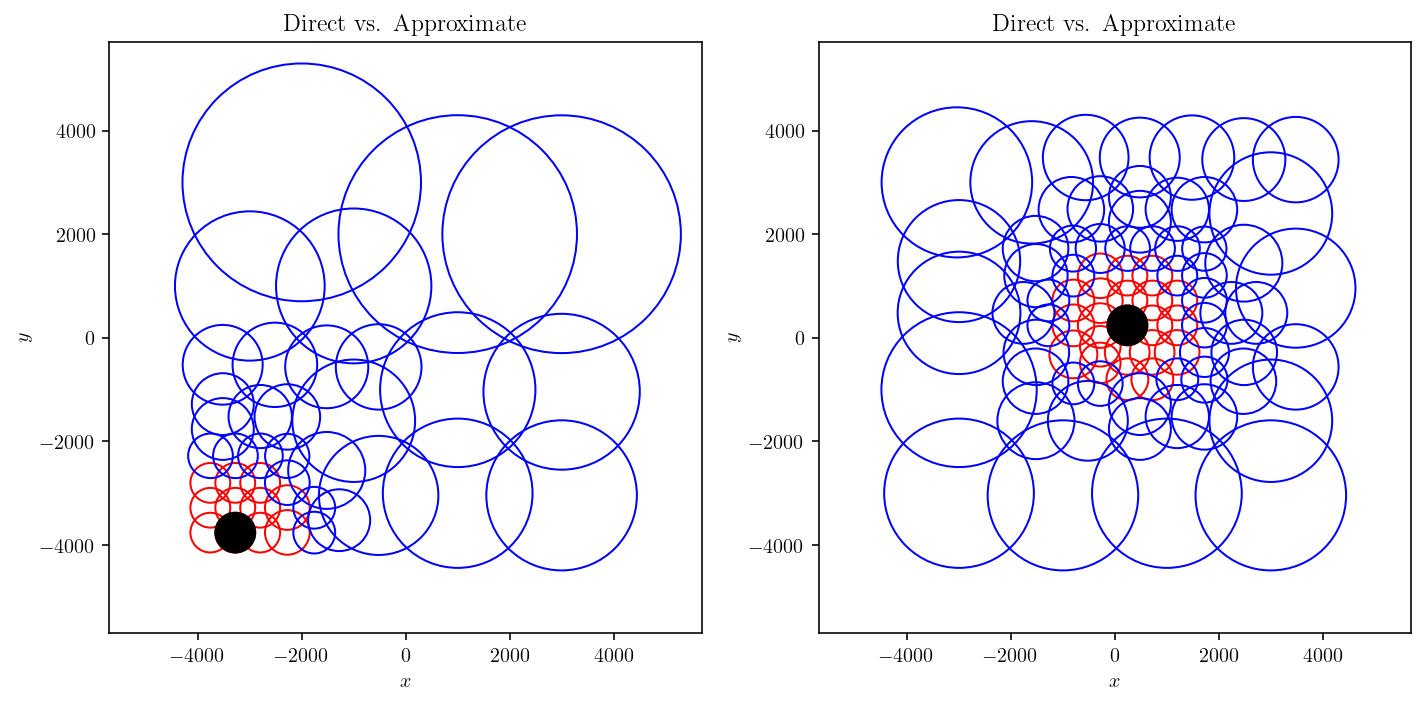

In [11]:
paths = [
    [0, 0, 0, 0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0, 0, 0, 0],
]
plt.figure(figsize=(10, 5))
for i, path in enumerate(paths):
    plt.subplot(1, 2, 1 + i)
    plt.title("Direct vs. Approximate")
    path_nodes = [tree.root]
    for p in path:
        path_nodes.append(path_nodes[-1].left if p == 0 else path_nodes[-1].right)

    for target_obsn in path_nodes:
        for obsn, srcn in direct:
            if obsn is target_obsn:
                circle = plt.Circle(
                    tuple(srcn.center[:2]), srcn.radius, fill=False, color="r"
                )
                plt.gca().add_patch(circle)

    for target_obsn in path_nodes:
        for obsn, srcn in approx:
            if obsn is target_obsn:
                circle = plt.Circle(
                    tuple(srcn.center[:2]), srcn.radius, fill=False, color="b"
                )
                plt.gca().add_patch(circle)
    circle = plt.Circle(
        tuple(target_obsn.center[:2]), target_obsn.radius, fill=True, color="k"
    )
    plt.gca().add_patch(circle)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.xlim(
        [tree.root.center[0] - tree.root.radius, tree.root.center[0] + tree.root.radius]
    )
    plt.ylim(
        [tree.root.center[1] - tree.root.radius, tree.root.center[1] + tree.root.radius]
    )
plt.tight_layout()
plt.show()

These figures make a few points:
* The nearest neighbor nodes interact directly. This is expected since we were hoping to operationalize the concept of "near-field".
* As we get further and further away from the observation node, the size of the source nodes becomes larger. 
* This second point can be rigorously elaborated on to derive the $O(n\log(n))$ scaling of many hierarchical matrix operations.

## Direct matrix blocks

This next step is less novel, but still necessary. Now that we've built both the direct and approximate interaction lists, we need to compute the actual matrices corresponding to each of those interactions.

The direct blocks are more of less as expected and can be implemented with the `cutde.disp_matrix` function that we've used several times already and as demonstrated below.

However, each of these matrix blocks is quite small. So, doing them one at a time is inefficient and defeats the point of using a highly-parallelized GPU TDE implementation (`cutde`). Luckily, there's a function designed just for this situation, `cutde.disp_block`. When we use `disp_block`, we can specify many contiguous sub-blocks of a larger matrix to be computed at once.

To get more precise, we pass the full set of observation points and source triangles and then also pass a list of the start and end indices of the observation points we want to compute a matrix block and a list of the start and end indices of the source triangles for each block. Also note that the return value is a contiguous block of memory, `packed_blocks` containing all the blocks packed together. The `block_starts` array contains indices where each block's entries start. The number of entries per block can be computed easily from the number of observation points and number of source triangles. 

I'll time this section of code and then also compare with the runtime of computing each block separately.

In [12]:
import time

for timing_iter in range(2):
    start = time.time()
    tree_tri_pts = surf_tri_pts[tree.ordered_idxs].astype(np.float32)
    tree_obs_pts = (np.mean(tree_tri_pts, axis=1) + np.array([0, 0, 0.01])).astype(
        np.float32
    )
    direct_obs_starts = np.array([d[0].idx_start for d in direct])
    direct_obs_ends = np.array([d[0].idx_end for d in direct])
    direct_src_starts = np.array([d[1].idx_start for d in direct])
    direct_src_ends = np.array([d[1].idx_end for d in direct])

    direct_packed_blocks, direct_block_starts = cutde.disp_block(
        tree_obs_pts,
        tree_tri_pts,
        direct_obs_starts,
        direct_obs_ends,
        direct_src_starts,
        direct_src_ends,
        0.25,
    )
    for i in range(direct_block_starts.shape[0] - 1):
        # We can't forget to rotate the source dimension into x-y-z instead of
        # the strike-dip-tensile coordinate system.
        # First, unpack the block into a (N, 3, M, 3) array.
        DD = direct_packed_blocks[
            direct_block_starts[i] : direct_block_starts[i + 1]
        ].reshape(
            (
                direct_obs_ends[i] - direct_obs_starts[i],
                3,
                direct_src_ends[i] - direct_src_starts[i],
                3,
            )
        )
        tmp = DD[:, :, :, 0].copy()
        DD[:, :, :, 0] = DD[:, :, :, 1]
        DD[:, :, :, 1] = tmp
        direct_packed_blocks[
            direct_block_starts[i] : direct_block_starts[i + 1]
        ] = DD.flatten()
    if timing_iter > 0:
        print(f"runtime {time.time() - start:.3} secs")

runtime 0.194 secs


In [13]:
def direct_block(obs_node, src_node, offset):
    src_tri_pts = tree_tri_pts[src_node.idx_start : src_node.idx_end].astype(np.float32)
    obs_tri_pts = tree_tri_pts[obs_node.idx_start : obs_node.idx_end].astype(np.float32)
    obs_pts = (np.mean(obs_tri_pts, axis=1) + np.array([0, 0, offset])).astype(
        np.float32
    )
    M = cutde.disp_matrix(obs_pts, src_tri_pts, 0.25)
    tmp = M[:, :, :, 0].copy()
    M[:, :, :, 0] = M[:, :, :, 1]
    M[:, :, :, 1] = tmp
    return M.reshape((obs_pts.shape[0] * 3, src_tri_pts.shape[0] * 3))


for timing_iter in range(2):
    start = time.time()
    direct_blocks = [direct_block(d[0], d[1], 0.01) for d in direct]
    if timing_iter > 0:
        print(f"runtime {time.time() - start:.3} secs")

runtime 2.81 secs


The `cutde.disp_blocks` version is about 15x faster. Below, we quickly check that both these implementations give exactly the same output, increasing my confidence that either one is correct.

In [14]:
packed_err = [
    np.max(
        direct_blocks[i].flatten()
        - direct_packed_blocks[direct_block_starts[i] : direct_block_starts[i + 1]]
    )
    for i in range(len(direct_blocks))
]
np.max(packed_err)

0.0

## Approximating a far-field matrix block

For the approximate blocks, the code is a bit more involved. But, it's basically just a wrapper around the `ACA_plus` from the last section. I'll add comments inline with the code to explain what's going on.

In [15]:
from aca import ACA_plus, SVD_recompress


def approx_block(obs_node, src_node, offset, eps, verbose=False):

    # Determine the source and observation points. This is slightly simplified
    # from the general case because we are computing the self-interaction of a
    # set of triangles with the centroids of those triangles. In a more general
    # case, the source triangles might be completely different from the
    # observation points.
    src_tri_pts = tree_tri_pts[src_node.idx_start : src_node.idx_end]
    obs_tri_pts = tree_tri_pts[obs_node.idx_start : obs_node.idx_end]
    obs_pts = np.mean(obs_tri_pts, axis=1) + np.array([0, 0, offset])

    # We need to pass a row calculation and a column calculation function to the
    # ACA_plus algorithm. The get_cols function will be basically identical
    # to the get_rows function so I'll just cover the rows version.
    def get_rows(Istart, Iend):
        # Istart and Iend are row indices for the matrix block under consideration.
        # But, we need to calculate in terms of observation point indices, not matrix row
        # indices. So, we divide by three.
        # This add a touch of complexity because, for example, if we want only a single matrix row,
        # we'll end up calculating all the rows for a single observation point. Thus, a few lines
        # below, we filter out the extra rows.
        obs_idx_start = Istart // 3
        obs_idx_end = (Iend - 1) // 3 + 1

        # Calculate the rows!
        rows = cutde.disp_matrix(obs_pts[obs_idx_start:obs_idx_end], src_tri_pts, 0.25)

        # Reshape the returned array and filter out the extra rows.
        n_rows_computed = 3 * (obs_idx_end - obs_idx_start)
        rows2d = rows.reshape((n_rows_computed, -1))
        local_start = Istart % 3
        local_end = local_start + Iend - Istart
        filter_out_extra = rows2d[local_start:local_end, :]

        return filter_out_extra

    def get_cols(Jstart, Jend):
        src_idx_start = Jstart // 3
        src_idx_end = (Jend - 1) // 3 + 1

        rows = cutde.disp_matrix(obs_pts, src_tri_pts[src_idx_start:src_idx_end], 0.25)
        n_cols_computed = 3 * (src_idx_end - src_idx_start)
        cols2d = rows.reshape((-1, n_cols_computed))

        local_start = Jstart % 3
        local_end = local_start + Jend - Jstart
        filter_out_extra = cols2d[:, local_start:local_end]
        return filter_out_extra

    n_rows = obs_pts.shape[0] * 3
    n_cols = src_tri_pts.shape[0] * 3

    # Call the ACA_plus algorithm.
    # Here, we're using eps / 50.0 to give a safety factor on the accuracy of the
    # approximation. Then, the SVD_recompress step in the next line reduces the
    # approximation to be more efficient.
    U, V = ACA_plus(n_rows, n_cols, get_rows, get_cols, eps / 50.0, verbose=verbose)
    U_SVD, V_SVD = SVD_recompress(U, V, eps)

    if V_SVD.shape[0] == 0:
        return U_SVD, V_SVD

    # Rotate out of the TDE coordinate system and return the result!
    V_SVD_reshaped = V_SVD.reshape((V_SVD.shape[0], -1, 3))
    tmp = V_SVD_reshaped[:, :, 0].copy()
    V_SVD_reshaped[:, :, 0] = V_SVD_reshaped[:, :, 1]
    V_SVD_reshaped[:, :, 1] = tmp
    return U_SVD, V_SVD_reshaped.reshape(V_SVD.shape)

And let's try out this new code! It's simple to compute the same block with both the `approx_block` and the `direct_block` functions and compare the results.

In [16]:
U, V = approx_block(approx[0][0], approx[0][1], 0.01, 1e-4, verbose=True)
true = direct_block(approx[0][0], approx[0][1], 0.01)
U.shape

pivot row=  53, pivot col=  43, step size=3.035e-03, tolerance=2.000e-06
pivot row=  51, pivot col=  44, step size=3.053e-03, tolerance=2.000e-06
pivot row=  17, pivot col=  21, step size=5.227e-04, tolerance=2.000e-06
pivot row=  34, pivot col=   5, step size=6.141e-04, tolerance=2.000e-06
pivot row=  36, pivot col=  62, step size=1.189e-04, tolerance=2.000e-06
pivot row=  38, pivot col=  61, step size=1.307e-04, tolerance=2.000e-06
pivot row=   5, pivot col=   1, step size=3.315e-05, tolerance=2.000e-06
pivot row=  15, pivot col=  17, step size=2.705e-05, tolerance=2.000e-06
pivot row=  35, pivot col=   0, step size=6.409e-06, tolerance=2.000e-06
pivot row=  52, pivot col=  23, step size=8.353e-06, tolerance=2.000e-06
pivot row=  37, pivot col=  53, step size=1.680e-06, tolerance=2.000e-06


/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:78: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(
/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:69: UserWarning: The tris input array has type float32 but needs to be converted to dtype float64. Converting tris to float64 may be expensive.
  warnings.warn(
/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:69: UserWarning: The tris input array has type float32 but needs to be converted to dtype float64. Converting tris to float64 may be expensive.
  warnings.warn(
/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:78: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(


(54, 4)

As requested, the Frobenius norm of the approximation error is slightly lower than `1e-4`.

In [17]:
np.sqrt(np.sum((U.dot(V) - true) ** 2))

9.584566994359383e-05

## Block tolerance

Great, now we have the infrastructure necessary for approximate far-field matrix blocks. But, there's one last thing to cover before constructing the full H-matrix. How do we translate a global matrix approximation tolerance into a local block-wise tolerance?

Given a large dense BEM matrix and the desire to approximate that matrix using H-matrix techniques, we'll presumably have some tolerance, $\varepsilon$ that is acceptable. For H-matrices, the tolerance is a relative constraint on the Frobenius norm difference between the approximate matrix and the true matrix:

\begin{equation}
\|E\|_{F} \leq \varepsilon \|B\|_{F}
\end{equation}
where $E$ is the error matrix and $B$ is the matrix we want to approximate.

That full-matrix tolerance needs to be translated into a tolerance that is used for each approximated block. On an intuitive level, a good option is to assign each block an error budget that is proportional to what percent of the entries of the full matrix that block makes up. In other words, we require that for a block with error $E_i$:
\begin{equation}
\|E_i\|_F \leq \varepsilon \sqrt{\frac{m_i n_i}{MN}} \|B\|_F
\end{equation}
where $m_i$ and $n_i$ are the number of rows and columns for the block and $M$ and $N$ are the number of rows and columns of the full matrix.

The {cite:t}`bradley2011hmatrix` bradley paper works through the details of this approach. 

It's important to always be clear about whether we're talking about a relative error or an absolute error. In the `ACA_plus` and `SVD_recompress` implementations, the error is specified in absolute terms. But, here the error is a relative error in terms of $\|B\|_F$, the Frobenius norm of the full matrix. 

In order to implement block-wise error tolerance, the only remaining puzzle is how to calculate $\|B\|_F$ itself. This actually turns out to be pretty simple: we can just sample several rows at random from the full matrix and compute a statistical estimate of the matrix norm. Let's do it:

In [18]:
n_samples = 20
row_idxs = np.random.randint(0, surf_centroids.shape[0], size=n_samples)
sample = cutde.disp_matrix(
    surf_centroids[row_idxs] + np.array([0, 0, 0.01]), surf_tri_pts, 0.25
)
sample.shape

(20, 3, 5000, 3)

Then, with [jackknife resampling](https://en.wikipedia.org/wiki/Jackknife_resampling), we can also recover a standard deviation for the norm estimate.

In [19]:
n_full_entries = (surf_centroids.shape[0] * 3) ** 2
frob2_ests = [
    np.sum(sample[i] ** 2) * (n_full_entries / sample[i].size) for i in range(n_samples)
]
frob2_mean = np.mean(frob2_ests)

jack_replicates = []
for i in range(n_samples):
    jack_replicates.append((n_samples * frob2_mean - frob2_ests[i]) / (n_samples - 1))
jack_mean = np.mean(jack_replicates)
jack_stddev = np.sqrt(
    np.sum((jack_replicates - jack_mean) ** 2) * ((n_samples - 1) / n_samples)
)
print("|B|_F^2 =", frob2_mean)
print("standard deviation", jack_stddev)

|B|_F^2 = 3805.066718948906
standard deviation 0.10520567808363768


And finally, because we want to upper bound the error, it's okay to have a slight underestimate of $\|B\|_F$. So, a fun trick is just to subtract twice the estimate standard deviation.

In [20]:
safe_frob2_est = frob2_mean - jack_stddev * 2
safe_frob2_est

3804.8563075927386

A quick comparison shows that our estimate of the norm is reasonable.

In [21]:
true_frob2 = np.sum(full_mat ** 2)
true_frob2

3804.0732

Finally, we can compute the tolerance for each block and plot two histograms:
1. A histogram of the number of blocks at each tolerance level.
2. A histogram of the total number of matrix entries at each tolerance level. 

This emphasizes that a looser tolerance is being applied to the larger blocks. That's great because it reduces the computational effort.

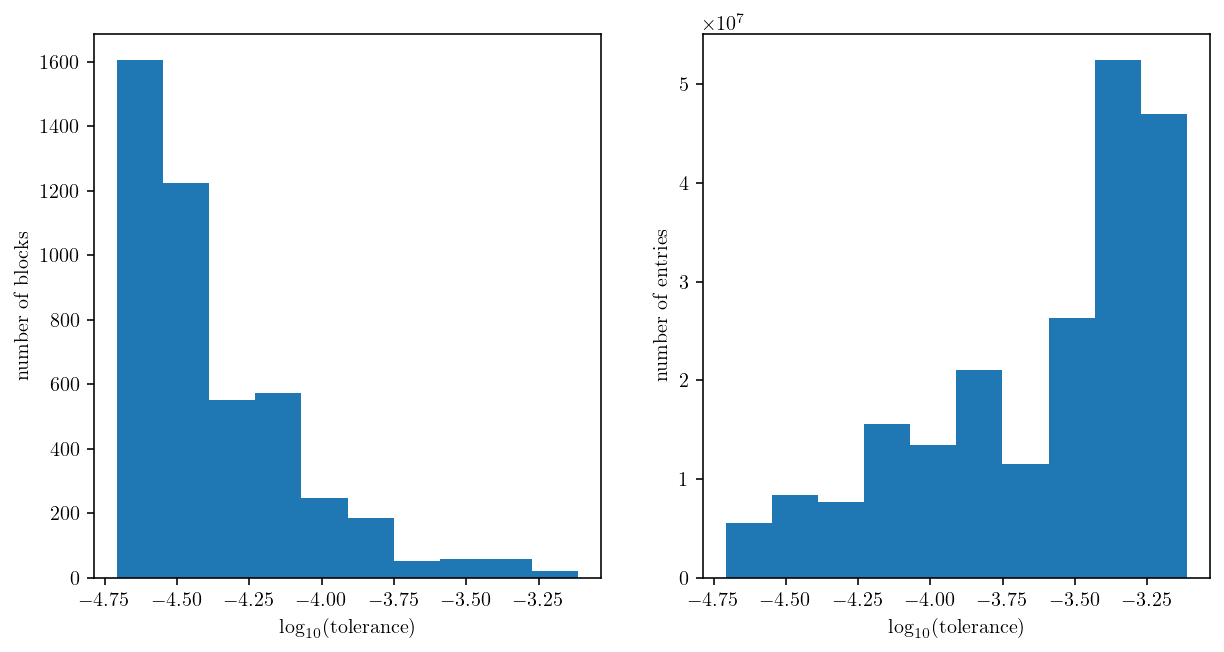

In [22]:
n_entries_per_block = np.array(
    [
        (obs_node.idx_end - obs_node.idx_start)
        * 3
        * (src_node.idx_end - src_node.idx_start)
        * 3
        for obs_node, src_node in approx
    ]
)
safe_frob_est = np.sqrt(safe_frob2_est)
eps = 1e-4
block_tolerances = eps * np.sqrt(n_entries_per_block / n_full_entries) * safe_frob_est

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(block_tolerances))
plt.xlabel("$\log_{10}(\\textrm{tolerance})$")
plt.ylabel("number of blocks")
plt.subplot(1, 2, 2)
plt.hist(np.log10(block_tolerances), weights=n_entries_per_block)
plt.xlabel("$\log_{10}(\\textrm{tolerance})$")
plt.ylabel("number of entries")
plt.show()

## Faster approximate blocks on GPUs with `cutde`

Given the previous approximation code and the block-wise error tolerance, you'd think we're ready to go for building the entire approximate portion of the H-matrix. And that's true. But, even for a fairly small problem like the one we're dealing with here, the Python implementation of the `ACA_plus` function is quite slow and would take several minutes to build all 4333 approximate blocks. So, instead, I implemented a GPU-optimized version in `cutde` with the `cutde.disp_aca` function.

In [23]:
len(approx)

4581

First, let's get a sense of the original Python performance by running only the first 100 blocks.

In [24]:
%%time
approx_blocks = []
for i, (obs_node, src_node) in enumerate(approx[:100]):
    n_entries = (
        (obs_node.idx_end - obs_node.idx_start)
        * 3
        * (src_node.idx_end - src_node.idx_start)
        * 3
    )
    U, V = approx_block(obs_node, src_node, 0.01, block_tolerances[i])
    approx_blocks.append((U, V))

/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:78: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(
/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:69: UserWarning: The tris input array has type float32 but needs to be converted to dtype float64. Converting tris to float64 may be expensive.
  warnings.warn(


CPU times: user 2.36 s, sys: 552 ms, total: 2.91 s
Wall time: 2.91 s


And since, if you haven't noticed already, I really like checking things, let's look at the Frobenius norm error between these approximations and the corresponding exact calculation. These are all below the requested tolerances.

In [25]:
for i in range(10):
    U, V = approx_blocks[i]
    true = direct_block(approx[i][0], approx[i][1], 0.01)
    error = np.sqrt(np.sum((U.dot(V) - true) ** 2))
    assert error < block_tolerances[i]
    if i == 0:
        print(
            f"All good! Error less than tolerance: {error:.3} < {block_tolerances[i]:.3}"
        )

All good! Error less than tolerance: 1.81e-05 < 2.4e-05


Here, we'll do essentially the same thing as the `approx_block` function above except we'll run for all the blocks simultaneously using `cutde.disp_aca`. 

The SVD recompression is not optimized beyond the version from before, but it requires much less time than ACA+. It would probably be possible to reduce the runtime of the SVD recompression by 5-20x using a parallel or GPU-optimized version. However, it's not currently slow enough to justify that.

In [26]:
%%time

approx_obs_starts = np.array([d[0].idx_start for d in approx])
approx_obs_ends = np.array([d[0].idx_end for d in approx])
approx_src_starts = np.array([d[1].idx_start for d in approx])
approx_src_ends = np.array([d[1].idx_end for d in approx])

n_rows = 3 * (approx_obs_ends - approx_obs_starts)
n_cols = 3 * (approx_src_ends - approx_src_starts)
max_iter = np.maximum(n_rows, n_cols) // 2

approx_blocks_gpu_aca = cutde.disp_aca(
    tree_obs_pts,
    tree_tri_pts,
    approx_obs_starts,
    approx_obs_ends,
    approx_src_starts,
    approx_src_ends,
    0.25,
    block_tolerances,
    max_iter,
)

approx_blocks_gpu = []
for U, V in approx_blocks_gpu_aca:
    U_SVD, V_SVD = SVD_recompress(U, V, block_tolerances[i])

    if V_SVD.shape[0] == 0:
        approx_blocks_gpu.append((U_SVD, V_SVD))
        continue

    # Rotate out of the TDE coordinate system.
    V_SVD_reshaped = V_SVD.reshape((V_SVD.shape[0], -1, 3))
    tmp = V_SVD_reshaped[:, :, 0].copy()
    V_SVD_reshaped[:, :, 0] = V_SVD_reshaped[:, :, 1]
    V_SVD_reshaped[:, :, 1] = tmp
    approx_blocks_gpu.append((U_SVD, V_SVD_reshaped.reshape(V_SVD.shape)))

CPU times: user 3.23 s, sys: 1.14 s, total: 4.37 s
Wall time: 2.72 s


Great! It seems that this implementation is about 43x faster per block because it built all the blocks in the same time that the Python implementation built just 100.

And a quick check to make sure the results match for the first ten blocks. I'm actually giving a factor of two extra tolerance because these tolerances are fairly small in comparison to single precision floating point epsilon.

In [27]:
for i in range(10):
    Upy, Vpy = approx_blocks[i]
    Ugpu, Vgpu = approx_blocks_gpu[i]

    est1 = Upy.dot(Vpy)
    est2 = Ugpu.dot(Vgpu)
    truth = direct_block(*approx[i], 0.01)

    est1_v_est2 = np.sqrt(np.sum((est1 - est2) ** 2))
    est2_v_truth = np.sqrt(np.sum((est2 - truth) ** 2))
    assert est1_v_est2 < 2 * block_tolerances[i]
    assert est2_v_truth < 2 * block_tolerances[i]

I'll also pack these blocks similar to how the direct blocks are packed into a single array. This will make for more efficient access later.

In [28]:
approx_max_rank = np.max([U.shape[1] for U, _ in approx_blocks_gpu])
UVflattened = [np.concatenate((V.flatten(), U.flatten())) for U, V in approx_blocks_gpu]
approx_block_starts = np.empty(len(UVflattened) + 1, dtype=np.int64)
approx_block_starts[0] = 0
approx_block_starts[1:] = np.cumsum([arr.size for arr in UVflattened])
approx_packed_blocks = np.concatenate(UVflattened)

Wow! We've finally built our full H-matrix! Since the whole point of this adventure has been to sparsify a dense matrix, let's see how much less memory the H-matrix uses. For this problem, the H-matrix uses about 1/9th the memory as the dense version. But, since the H-matrix scales almost linearly and the dense version scales quadratically, this compression will rapidly increase for larger problems. In the next TDE section, we'll build a much bigger H-matrix and deal with a problem that would be infeasible to handle without compression.

In [29]:
approx_nbytes = approx_packed_blocks.nbytes
direct_nbytes = direct_packed_blocks.nbytes
hmatrix_nbytes = approx_nbytes + direct_nbytes
dense_nbytes = (surf_tris.shape[0] * 3) ** 2 * 4
print(f"dense size = {dense_nbytes / 1e9:.3} GB")
print(f"hmatrix size = {hmatrix_nbytes / 1e9:.3} GB")
print(f"direct size = {direct_nbytes / 1e9:.3} GB")
print(f"approx size = {approx_nbytes / 1e9:.3} GB")
print(f"compression factor = {dense_nbytes / hmatrix_nbytes:.3}X smaller")

dense size = 0.9 GB
hmatrix size = 0.0982 GB
direct size = 0.0638 GB
approx size = 0.0344 GB
compression factor = 9.17X smaller


## A matrix-vector product

We're not just trying to reduce memory usage. I'd also like to see reduced runtime. So, the final step here is to actually use the matrix! Let's run a quick matrix-vector product as a performance and accuracy demonstration. 

First, the correct answer, using the `full_mat` that we built way back at the beginning of this section.

In [30]:
n_cols = n_rows = surf_tri_pts.shape[0] * 3
x = np.random.rand(n_cols).astype(np.float32)
x_tree = x.reshape((tree.ordered_idxs.shape[0], 3))[tree.ordered_idxs].reshape((-1))
full_mat2d = full_mat.reshape((n_rows, n_cols))
y_true = full_mat2d.dot(x)

For a fair performance comparison with the numpy matrix-vector product, we need our own parallelized and compiled block-wise matrix-vector product. So, I'll use Cython to implement some optimized block-wise matrix-vector operations. I think it's sort of out-of-scope to launch into a Cython tutorial here, but this could be a fun chunk of code to learn from since it's short and sweet. Here a few good introductions to Cython:
* [Basic Cython Tutorial](https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html)
* [Typed memoryviews are super helpful for interacting with numpy](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html#memoryviews)
* [More info for numpy <--> Cython interoperation](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html)

In [31]:
%load_ext cython

In [32]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose
#cython: boundscheck=False, wraparound=False
import numpy as np
from cython.parallel import prange
cimport cython
cimport openmp

# Cython doesn't support OpenMP atomic operations so we very briefly drop 
# into C here.
cdef extern from *:
    """
    void omp_atomic_add(float* x, float y) {
        #pragma omp atomic
        *x += y;
    }
    """
    void omp_atomic_add(float* x, float y) nogil

cdef void single_block_dot(long n_rows, long n_cols,  
                           float* packed_blocks, float* x, 
                           float* y) nogil:
    cdef int row_start
    cdef int i, j
    cdef float out_v
    for i in range(n_rows):
        row_start = i * n_cols
        out_v = 0
        for j in range(n_cols):
            out_v += packed_blocks[row_start + j] * x[j]
        # Since the outer block loop is parallelized, it's possible
        # for two threads to update the same data at the same time. So,
        # use a safe atomic operation.
        omp_atomic_add(&y[i], out_v)

def direct_dot(long[::1] obs_start, long[::1] obs_end, 
              long[::1] src_start, long[::1] src_end, 
              float[::1] packed_blocks, long[::1] block_starts, 
              float[::1] x_tree):
    cdef int k
    cdef int block_obs_start, block_src_start
    cdef int block_obs_end, block_src_end
    cdef int block_start, n_rows, n_cols
    cdef y_tree_arr = np.zeros(x_tree.shape[0], dtype=np.float32)
    cdef float[::1] y_tree = y_tree_arr
    
    for k in prange(obs_start.shape[0], nogil=True):
        single_block_dot(
            obs_end[k] * 3 - obs_start[k] * 3, 
            src_end[k] * 3 - src_start[k] * 3, 
            &packed_blocks[block_starts[k]], &x_tree[src_start[k] * 3], 
            &y_tree[obs_start[k] * 3]
        )
    return y_tree_arr

cdef float* get_ptr_from_array(X):
    cdef float[::, ::1] X_view = X
    cdef float* X_ptr = &X_view[0, 0]
    return X_ptr

def approx_dot(long[::1] obs_start, long[::1] obs_end, 
               long[::1] src_start, long[::1] src_end, 
               float[::1] packed_blocks, long[::1] block_starts,
               long max_rank,
               float[::1] x_tree):
    
    cdef y_tree_arr = np.zeros(x_tree.shape[0], dtype=np.float32)
    cdef float[::1] y_tree = y_tree_arr
    
    cdef int n_threads = openmp.omp_get_max_threads()
    cdef temp_buffer = np.empty(n_threads * max_rank, dtype=np.float32)
    cdef float[::1] temp_buffer_view = temp_buffer
    
    cdef int thread_id
    cdef int i, k, n_entries, n_cols, n_rows, rank
    cdef float* thread_buffer_ptr
    cdef float* U_ptr
    cdef float* V_ptr
    
    for k in prange(obs_start.shape[0], nogil=True):
        
        n_entries = block_starts[k+1] - block_starts[k]
        n_rows = (obs_end[k] - obs_start[k]) * 3
        n_cols = (src_end[k] - src_start[k]) * 3
        rank = n_entries // (n_cols + n_rows)
        
        V_ptr = &packed_blocks[block_starts[k]]
        U_ptr = &V_ptr[n_cols * rank]
        
        thread_id = openmp.omp_get_thread_num()
        thread_buffer_ptr = &temp_buffer_view[thread_id * max_rank]
        for i in range(rank):
            thread_buffer_ptr[i] = 0.0
        
        single_block_dot(
            rank, n_cols, 
            V_ptr, &x_tree[src_start[k] * 3], 
            thread_buffer_ptr
        )
        single_block_dot(
            n_rows, rank, 
            U_ptr, thread_buffer_ptr,
            &y_tree[obs_start[k] * 3]
        )
    return y_tree_arr

And I'll quickly check that both these functions work the way I expect. They should produce the same output as a manual Python loop over the blocks. And they do!

In [33]:
y_direct = np.zeros(n_rows)
for i in range(len(direct)):
    obs_node, src_node = direct[i]
    x_chunk = x_tree[src_node.idx_start * 3 : src_node.idx_end * 3]
    y_chunk = direct_blocks[i].dot(x_chunk)
    y_direct[obs_node.idx_start * 3 : obs_node.idx_end * 3] += y_chunk

y_direct2 = direct_dot(
    direct_obs_starts,
    direct_obs_ends,
    direct_src_starts,
    direct_src_ends,
    direct_packed_blocks,
    direct_block_starts,
    x_tree,
)

print(np.max(np.abs(y_direct2 - y_direct)))

3.708992153406143e-07


In [34]:
y_approx = np.zeros(n_rows)
for i in range(len(approx_blocks_gpu)):
    obs_node, src_node = approx[i]
    x_chunk = x_tree[src_node.idx_start * 3 : src_node.idx_end * 3]
    U, V = approx_blocks_gpu[i]
    y_chunk = U.dot(V.dot(x_chunk))
    y_approx[obs_node.idx_start * 3 : obs_node.idx_end * 3] += y_chunk

y_approx2 = approx_dot(
    approx_obs_starts,
    approx_obs_ends,
    approx_src_starts,
    approx_src_ends,
    approx_packed_blocks,
    approx_block_starts,
    approx_max_rank,
    x_tree,
)

print(np.max(np.abs(y_approx - y_approx2)))

2.34867911785841e-08


Putting all the pieces together for an H-matrix matrix-vector product results in:
1. Convert inputs into "tree ordering".
2. Calculate exact/direct blocks.
3. Calculate the far-field approximate blocks.
4. Sum the two and convert back into the "input ordering".

In [35]:
def hmatrix_dot(x):
    # Use tree.ordered_idxs to convert from the input
    # ordering to the tree ordering.
    x_tree = x.reshape((tree.ordered_idxs.shape[0], 3))[tree.ordered_idxs].reshape((-1))
    y_direct = direct_dot(
        direct_obs_starts,
        direct_obs_ends,
        direct_src_starts,
        direct_src_ends,
        direct_packed_blocks,
        direct_block_starts,
        x_tree,
    )

    y_approx = approx_dot(
        approx_obs_starts,
        approx_obs_ends,
        approx_src_starts,
        approx_src_ends,
        approx_packed_blocks,
        approx_block_starts,
        approx_max_rank,
        x_tree,
    )

    # Convert back from the tree ordering into the input ordering.
    y_hmatrix = np.empty(n_rows)
    y_hmatrix.reshape((-1, 3))[tree.ordered_idxs, :] = (y_approx + y_direct).reshape(
        (-1, 3)
    )
    return y_hmatrix

And, the relative $L^2$ and $L^{\infty}$ errors look great!

In [36]:
y_hmatrix = hmatrix_dot(x)

l2_rel_error = np.sqrt(np.mean((y_hmatrix - y_true) ** 2)) / np.sqrt(
    np.mean(y_true ** 2)
)
linf_rel_error = np.max(np.abs(y_hmatrix - y_true)) / np.max(np.abs(y_true))
print("L2 error: ", l2_rel_error)
print("Linf error: ", linf_rel_error)

L2 error:  0.007833145080236994
Linf error:  0.017134746769055426


In [37]:
%%timeit
y_true = full_mat2d.dot(x)

20.5 ms ± 93.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%%timeit
y_matrix = hmatrix_dot(x)

5.82 ms ± 53.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


And that's it! The H-matrix implementation works, is using 9x less memory and is running 4x faster. I'll leaving a full application of these tools for the next section.

A quick performance note: Even thought the H-matrix vector product is faster and uses less memory, this comparison is a bit unfair to the H-matrix algorithm for two reasons:
1. This is a pretty small problem for using H-matrices. If we had ten times as many elements, the H-matrix implementations would be a slam dunk!
2. The BLAS implementation behind the numpy matrix-vector product has been optimized to the hilt. On my machine, it's using OpenBLAS which should be achieving something near the peak possible performance for a dense matrix-vector. On the other hand, the  Cython code above is not optimized to that level. Many improvements are possible -- explicit vectorization (AVX, AVX-512), loop unrolling, removing the atomic operations, arranging the memory better etc, etc, etc. There's probably another factor of 2-3x on the table. So, the fact that, despite this disadvantage, the H-matrix implementation is several times faster than the dense matrix-vector product is super exciting! 

## Potential extensions

There are a lot of improvements that we could make here:
* Moving the matrix-vector production evaluation onto the GPU. Dense matrix-vector products are perfect for GPUs and would likely run several times faster than the parallel CPU version here. However, I wanted to have a fair comparison with the CPU dense matrix-vector product here. This might be a good section to add in here later!
* Performance optimization of the SVD recompression.
* There are many other $O(n)$ sparsification methods for these types of problems. 
  * The fast multipole method is extremely fast and effective.
  * $\mathcal{H}^2$ methods are an extension of H-matrices and further improve both memory usage and runtime.
* There's plenty of room for improvement in the tree construction to do a better job deciding which blocks can be approximated.
* It's possible to perform efficient LU decomposition of an H-matrix {cite:p}`Bebendorf2004`. That would be super useful for problems where we're solving many problems using the same left hand side matrix (e.g. time dependent problem). 
* And many more!